In [19]:
import pandas as pd
import numpy as np
import os

def extract_features_from_file(filepath, selected_columns):
    df = pd.read_csv(filepath)
    df_selected = df[selected_columns]

    features = {}
    for col in df_selected.columns:
        features[f'{col}_mean'] = df_selected[col].mean()
        features[f'{col}_std'] = df_selected[col].std()
        features[f'{col}_max'] = df_selected[col].max()
        features[f'{col}_min'] = df_selected[col].min()
        features[f'{col}_skew'] = df_selected[col].skew()
        features[f'{col}_kurtosis'] = df_selected[col].kurtosis()

        fft_vals = np.fft.fft(df_selected[col].values)
        features[f'{col}_fft_energy'] = np.sum(np.abs(fft_vals)**2)

    return features

# Sensör isimleri (Speed_Range dahil değil, çünkü ayrı işleniyor)
selected_columns = ['Voice', 'Acceleration X', 'Acceleration Y', 'Acceleration Z',
                    'Gyro X', 'Gyro Y', 'Gyro Z', 'Temperature']

# Etiketi 2'ye ayıran fonksiyon
def extract_labels(filename):
    """
    Dosya adındaki etiketleri ikiye ayırır:
    - healthy: 1 (varsa), 0 (yoksa)
    - label: scratch, notchlong, vs. (asıl sınıf)
    """
    correction_map = {
        'scracth': 'scratch',
        'scratch': 'scratch',
        'notchshort': 'notchshort',
        'notchlong': 'notchlong',
        'singlecutshort': 'singlecutshort',
        'singlecutlong': 'singlecutlong',
        'twocutshort': 'twocutshort',
        'twocutlong': 'twocutlong',
        'warped': 'warped'
    }

    name = filename.replace('.csv', '').lower()
    is_healthy = 'healthy' in name  # 'healthy' geçiyorsa flag = 1

    for wrong, correct in correction_map.items():
        if wrong in name:
            return int(is_healthy), correct

    return int(is_healthy), 'unknown'

# Ana veri işleme döngüsü
data_dir = "./PM980"
all_features = []

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_dir, filename)
        
        # Özellikleri çıkar
        feats = extract_features_from_file(file_path, selected_columns)
        
        # Etiketleri çıkar
        healthy_flag, class_label = extract_labels(filename)
        feats['healthy'] = healthy_flag
        feats['label'] = class_label
        
        all_features.append(feats)

# DataFrame'e dönüştür
dataset = pd.DataFrame(all_features)

# İlk 5 satırı göster
print(dataset.head())


    Voice_mean    Voice_std  Voice_max  Voice_min  Voice_skew  Voice_kurtosis  \
0  1806.032967  1221.860293     2929.0        0.0   -0.528839       -1.435130   
1  1512.358974  1040.519258     2928.0        0.0   -0.132362       -1.340961   
2  1535.084249  1140.095331     2931.0        0.0   -0.041191       -1.550754   
3  1551.772242  1058.629342     2929.0        0.0   -0.047593       -1.401144   
4  1446.236264  1023.724270     2928.0        0.0    0.003955       -1.351342   

   Voice_fft_energy  Acceleration X_mean  Acceleration X_std  \
0      3.539553e+11            -0.100476            1.515003   
1      2.508605e+11            -0.300659            1.033955   
2      2.721456e+11             0.038278            5.816020   
3      2.783142e+11            -0.116299            1.424842   
4      9.353960e+11            -0.329579            1.670196   

   Acceleration X_max  ...  Gyro Z_fft_energy  Temperature_mean  \
0                4.45  ...       1.648962e+05         27.1673

In [20]:
print(dataset['label'].value_counts())
print(dataset['healthy'].value_counts())

label
notchlong         60
notchshort        60
scratch           60
singlecutlong     60
singlecutshort    60
twocutlong        60
twocutshort       60
warped            60
Name: count, dtype: int64
healthy
1    240
0    240
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14516\4185981326.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  top_features = pd.unique(top_15_pairs.index.get_level_values(0).tolist() +


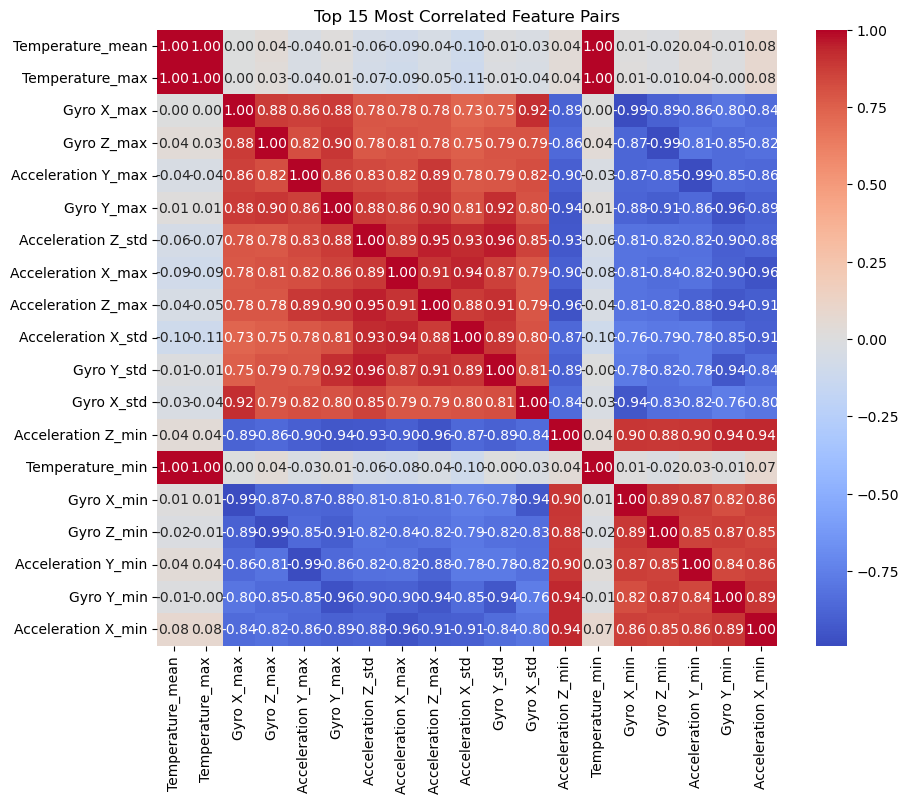

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Sayısal sütunları al, 'healthy' gibi istenmeyen sütunları çıkar
dataset_numeric = dataset.select_dtypes(include=[np.number]).drop(columns=['healthy'], errors='ignore')

# Korelasyon matrisini hesapla
corr_matrix = dataset_numeric.corr()

# Üst üçgen dışındaki elemanları maskele (tekrarları ve diagonal hariç)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.mask(mask)

# Korelasyonları seriye çevir ve mutlak değere göre sırala
sorted_pairs = corr_matrix_masked.unstack().dropna().sort_values(key=lambda x: abs(x), ascending=False)

# En yüksek 15 korelasyonu seç
top_15_pairs = sorted_pairs[:15]

# Bu çiftlerde geçen tüm benzersiz değişkenleri al
top_features = pd.unique(top_15_pairs.index.get_level_values(0).tolist() + 
                         top_15_pairs.index.get_level_values(1).tolist())

# Bu değişkenlerle sınırlı küçük bir korelasyon matrisi oluştur
top_corr_matrix = dataset_numeric[top_features].corr()

# Görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Top 15 Most Correlated Feature Pairs')
plt.show()


In [29]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [31]:
le = LabelEncoder()
y_encoded = le.fit_transform(dataset['label'])
class_names = le.classes_

# Eğitime dahil edilmeyecek
X = dataset.drop(columns=['label', 'healthy', 'label_encoded'], errors='ignore')
y = y_encoded

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=13)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 10-fold Stratified CV (train verisi içinde)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

# RandomForest Model
model = RandomForestClassifier(random_state=13)
metrics_rf = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'train_time': [], 'test_time': []}
per_class_reports = []  # sınıf bazlı metrikler için liste

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    start_train = time.time()
    model.fit(X_tr, y_tr)
    end_train = time.time()

    start_test = time.time()
    y_val_pred = model.predict(X_val)
    end_test = time.time()

    metrics_rf['accuracy'].append(accuracy_score(y_val, y_val_pred))
    metrics_rf['precision'].append(precision_score(y_val, y_val_pred, average='macro'))
    metrics_rf['recall'].append(recall_score(y_val, y_val_pred, average='macro'))
    metrics_rf['f1'].append(f1_score(y_val, y_val_pred, average='macro'))
    metrics_rf['train_time'].append(end_train - start_train)
    metrics_rf['test_time'].append(end_test - start_test)

    # Sınıf bazlı metrikleri fold bazında kaydet
    report = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True, zero_division=0)
    per_class_reports.append(pd.DataFrame(report).T)

# Genel CV sonuçları
print("Random Forest - 10-Fold CV Ortalamaları:")
results_df = pd.DataFrame(metrics_rf)
print(results_df.mean())

# Sınıf bazlı CV ortalama metrikler
# Fold'lardaki sınıf bazlı raporları birleştirip ortalamasını al
classwise_cv_report = pd.concat(per_class_reports).groupby(level=0).mean()

# Sadece sınıflara ait kısmı seçme (accuracy, macro avg gibi genel satırlar çıkarma)
class_indices = [c for c in class_names if c in classwise_cv_report.index]
classwise_clean = classwise_cv_report.loc[class_indices]

print("\nRandom Forest 10-Fold CV Sınıf Bazlı Ortalama Metrikler:")
print(classwise_clean[['precision', 'recall', 'f1-score', 'support']])

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print("\nRandom Forest Test Set Sınıf Bazlı Metrikler:")
print(classification_report(y_test, y_test_pred, target_names=class_names))


Random Forest - 10-Fold CV Ortalamaları:
accuracy      0.507422
precision     0.524395
recall        0.505625
f1            0.490764
train_time    0.452706
test_time     0.010635
dtype: float64

Random Forest 10-Fold CV Sınıf Bazlı Ortalama Metrikler:
                precision  recall  f1-score  support
notchlong        0.609762   0.580  0.568586      4.8
notchshort       0.379127   0.455  0.402460      4.8
scratch          0.586310   0.600  0.577031      4.8
singlecutlong    0.437143   0.395  0.399127      4.8
singlecutshort   0.480000   0.480  0.469543      4.8
twocutlong       0.667500   0.540  0.560495      4.8
twocutshort      0.590476   0.520  0.518283      4.8
warped           0.444841   0.475  0.430586      4.8

Random Forest Test Set Sınıf Bazlı Metrikler:
                precision    recall  f1-score   support

     notchlong       0.80      0.67      0.73        12
    notchshort       0.58      0.58      0.58        12
       scratch       0.62      0.67      0.64        12

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost Model
xgb_model = XGBClassifier(random_state=13, eval_metric='mlogloss')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

metrics_xgb = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'train_time': [], 'test_time': []}
train_times = []
test_times = []
per_class_reports = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    start_train = time.time()
    xgb_model.fit(X_tr, y_tr)
    end_train = time.time()

    start_test = time.time()
    y_pred = xgb_model.predict(X_val)
    end_test = time.time()

    train_times.append(end_train - start_train)
    test_times.append(end_test - start_test)

    metrics_xgb['accuracy'].append(accuracy_score(y_val, y_pred))
    metrics_xgb['precision'].append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_xgb['recall'].append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_xgb['f1'].append(f1_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_xgb['train_time'].append(end_train - start_train)
    metrics_xgb['test_time'].append(end_test - start_test)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    per_class_reports.append(pd.DataFrame(report).T)

# Sınıf bazlı metriklerin fold'lar bazında ortalaması
classwise_cv_report = pd.concat(per_class_reports).groupby(level=0).mean()

print("10-Fold CV Ortalamaları:")
print(f"Accuracy  : {np.mean(metrics_xgb['accuracy']):.4f}")
print(f"Precision : {np.mean(metrics_xgb['precision']):.4f}")
print(f"Recall    : {np.mean(metrics_xgb['recall']):.4f}")
print(f"F1 Score  : {np.mean(metrics_xgb['f1']):.4f}")
print(f"Train Time Avg: {np.mean(train_times):.4f} s")
print(f"Test Time Avg : {np.mean(test_times):.4f} s")


class_indices = list(map(str, range(len(class_names))))
classwise_clean = classwise_cv_report.loc[class_indices]
classwise_clean.index = [class_names[int(i)] for i in classwise_clean.index]

print("\nSınıf Bazlı CV Ortalama Metrikler:")
print(classwise_clean[['precision', 'recall', 'f1-score', 'support']])

# Test seti değerlendirme (final model)
xgb_model.fit(X_train, y_train)
y_test_pred = xgb_model.predict(X_test)

print("\nTest Seti - Sınıf Bazlı Metrikler:")
print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))


10-Fold CV Ortalamaları:
Accuracy  : 0.4919
Precision : 0.5296
Recall    : 0.4944
F1 Score  : 0.4827
Train Time Avg: 0.5641 s
Test Time Avg : 0.0053 s

Sınıf Bazlı CV Ortalama Metrikler:
                precision  recall  f1-score  support
notchlong        0.624524   0.680  0.643102      4.8
notchshort       0.489286   0.395  0.388919      4.8
scratch          0.656032   0.665  0.639107      4.8
singlecutlong    0.420476   0.405  0.402727      4.8
singlecutshort   0.439524   0.405  0.383362      4.8
twocutlong       0.726667   0.565  0.602525      4.8
twocutshort      0.481667   0.500  0.470339      4.8
warped           0.398730   0.340  0.331736      4.8

Test Seti - Sınıf Bazlı Metrikler:
                precision    recall  f1-score   support

     notchlong       0.82      0.75      0.78        12
    notchshort       0.67      0.50      0.57        12
       scratch       0.69      0.75      0.72        12
 singlecutlong       0.73      0.92      0.81        12
singlecutshort     


LightGBM 10-Fold CV Ortalamaları:
Accuracy  : 0.5388
Precision : 0.5793
Recall    : 0.5388
F1        : 0.5294
Train Time Avg: 0.6159 s
Test Time Avg : 0.0034 s

Sınıf Bazlı CV Ortalama Metrikler:
                precision  recall  f1-score  support
notchlong        0.789762   0.680  0.688203      4.8
notchshort       0.498810   0.475  0.470671      4.8
scratch          0.664722   0.685  0.647399      4.8
singlecutlong    0.602143   0.525  0.534211      4.8
singlecutshort   0.410000   0.385  0.361197      4.8
twocutlong       0.779167   0.640  0.656793      4.8
twocutshort      0.488810   0.480  0.469720      4.8
warped           0.400714   0.440  0.407385      4.8

Test Seti - Sınıf Bazlı Metrikler:
                precision    recall  f1-score   support

     notchlong       0.83      0.83      0.83        12
    notchshort       0.78      0.58      0.67        12
       scratch       0.77      0.83      0.80        12
 singlecutlong       0.67      0.83      0.74        12
singlecut

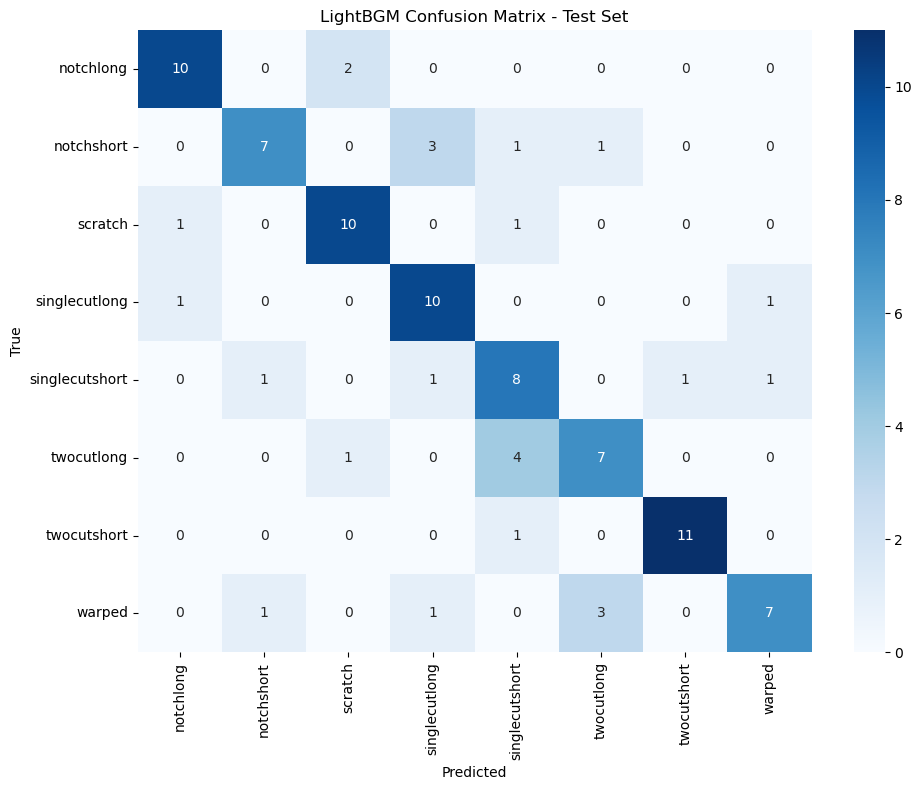

In [45]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb

# Stratified 10-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

# LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=13, verbose=-1)

# Genel metrikler
metrics_lgb = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'train_time': [], 'test_time': []}

# Sınıf bazlı metrikleri toplamak için
per_class_reports = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Eğitim süresi
    start_train = time.time()
    lgb_model.fit(X_tr, y_tr)
    end_train = time.time()

    # Tahmin süresi
    start_test = time.time()
    y_pred = lgb_model.predict(X_val)
    end_test = time.time()

    # Genel metrikler
    metrics_lgb['accuracy'].append(accuracy_score(y_val, y_pred))
    metrics_lgb['precision'].append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_lgb['recall'].append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_lgb['f1'].append(f1_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_lgb['train_time'].append(end_train - start_train)
    metrics_lgb['test_time'].append(end_test - start_test)

    # Sınıf bazlı metrikler
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    per_class_reports.append(pd.DataFrame(report).T)

# Cross-validation ortalama skorları
print("\nLightGBM 10-Fold CV Ortalamaları:")
for key in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"{key.capitalize():<10}: {np.mean(metrics_lgb[key]):.4f}")
print(f"Train Time Avg: {np.mean(metrics_lgb['train_time']):.4f} s")
print(f"Test Time Avg : {np.mean(metrics_lgb['test_time']):.4f} s")

# Sınıf bazlı CV ortalamaları
classwise_cv_report = pd.concat(per_class_reports).groupby(level=0).mean()


class_indices = list(map(str, range(len(class_names))))
classwise_clean = classwise_cv_report.loc[class_indices]
classwise_clean.index = [class_names[int(i)] for i in classwise_clean.index]

print("\nSınıf Bazlı CV Ortalama Metrikler:")
print(classwise_clean[['precision', 'recall', 'f1-score', 'support']])

# Test seti değerlendirme 
lgb_model.fit(X_train, y_train)
y_test_pred = lgb_model.predict(X_test)

print("\nTest Seti - Sınıf Bazlı Metrikler:")
print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("LightBGM Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
import numpy as np
import pandas as pd

# Model ve CV
knn = KNeighborsClassifier(n_neighbors=5)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

# Metriklerin ve zamanların tutulacağı sözlükler
metrics_knn = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'train_time': [], 'test_time': []}
train_times = []
test_times = []

# Sınıf bazlı raporları tutacak liste
per_class_reports = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Eğitim süresi
    start_train = time.time()
    knn.fit(X_tr, y_tr)
    end_train = time.time()

    # Tahmin süresi
    start_test = time.time()
    y_pred = knn.predict(X_val)
    end_test = time.time()

    # Zamanları kaydet
    train_times.append(end_train - start_train)
    test_times.append(end_test - start_test)

    # Genel metrikleri kaydet
    metrics_knn['accuracy'].append(accuracy_score(y_val, y_pred))
    metrics_knn['precision'].append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_knn['recall'].append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_knn['f1'].append(f1_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_knn['train_time'].append(end_train - start_train)
    metrics_knn['test_time'].append(end_test - start_test)

    # Sınıf bazlı raporu topla
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    per_class_reports.append(pd.DataFrame(report).T)

# Cross-validation genel metrik ortalamaları
print("\nKNN - 10-Fold CV Genel Ortalamalar:")
print(f"Accuracy  : {np.mean(metrics_knn['accuracy']):.4f}")
print(f"Precision : {np.mean(metrics_knn['precision']):.4f}")
print(f"Recall    : {np.mean(metrics_knn['recall']):.4f}")
print(f"F1 Score  : {np.mean(metrics_knn['f1']):.4f}")
print(f"Train Time Avg: {np.mean(train_times):.4f} s")
print(f"Test Time Avg : {np.mean(test_times):.4f} s")

# Sınıf bazlı CV ortalama metrikleri (fold'lar üzerindeki ortalama)
classwise_cv_report = pd.concat(per_class_reports).groupby(level=0).mean()


class_indices = [str(i) for i in range(len(class_names))]
classwise_clean = classwise_cv_report.loc[class_indices]
classwise_clean.index = [class_names[int(i)] for i in classwise_clean.index]

print("\nKNN - Sınıf Bazlı CV Ortalama Metrikler:")
print(classwise_clean[['precision', 'recall', 'f1-score', 'support']])

# Final model eğitimi ve test seti performansı
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)

print("\nKNN Test Seti - Sınıf Bazlı Metrikler:")
print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))



KNN - 10-Fold CV Genel Ortalamalar:
Accuracy  : 0.1482
Precision : 0.1622
Recall    : 0.1469
F1 Score  : 0.1425
Train Time Avg: 0.0020 s
Test Time Avg : 0.0255 s

KNN - Sınıf Bazlı CV Ortalama Metrikler:
                precision  recall  f1-score  support
notchlong        0.103056   0.140  0.101289      4.8
notchshort       0.146786   0.165  0.148559      4.8
scratch          0.090278   0.105  0.094605      4.8
singlecutlong    0.344524   0.315  0.316198      4.8
singlecutshort   0.072619   0.085  0.077071      4.8
twocutlong       0.121786   0.145  0.129487      4.8
twocutshort      0.368333   0.200  0.244127      4.8
warped           0.050000   0.020  0.028571      4.8

KNN Test Seti - Sınıf Bazlı Metrikler:
                precision    recall  f1-score   support

     notchlong       0.04      0.08      0.06        12
    notchshort       0.25      0.25      0.25        12
       scratch       0.14      0.08      0.11        12
 singlecutlong       0.36      0.42      0.38        

In [41]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import time

# Stratified 10-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

# CatBoost Model
cat_model = CatBoostClassifier(random_state=13, verbose=0)


metrics_cat = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'train_time': [], 'test_time': []}

# Sınıf bazlı metrikleri toplamak için
per_class_reports_cat = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Eğitim süresi
    start_train = time.time()
    cat_model.fit(X_tr, y_tr)
    end_train = time.time()

    # Tahmin süresi
    start_test = time.time()
    y_pred = cat_model.predict(X_val)
    end_test = time.time()

    # Genel metrikler
    metrics_cat['accuracy'].append(accuracy_score(y_val, y_pred))
    metrics_cat['precision'].append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_cat['recall'].append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_cat['f1'].append(f1_score(y_val, y_pred, average='macro', zero_division=0))
    metrics_cat['train_time'].append(end_train - start_train)
    metrics_cat['test_time'].append(end_test - start_test)

    # Sınıf bazlı metrikler
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    per_class_reports_cat.append(pd.DataFrame(report).T)

# Cross-validation ortalama skorları
print("\nCatBoost 10-Fold CV Ortalamaları:")
for key in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"{key.capitalize():<10}: {np.mean(metrics_cat[key]):.4f}")
print(f"Train Time Avg: {np.mean(metrics_cat['train_time']):.4f} s")
print(f"Test Time Avg : {np.mean(metrics_cat['test_time']):.4f} s")

# Sınıf bazlı CV ortalamaları
classwise_cv_report_cat = pd.concat(per_class_reports_cat).groupby(level=0).mean()


class_indices = list(map(str, range(len(class_names))))
classwise_clean_cat = classwise_cv_report_cat.loc[class_indices]
classwise_clean_cat.index = [class_names[int(i)] for i in classwise_clean_cat.index]

print("\nCatBoost - Sınıf Bazlı CV Ortalama Metrikler:")
print(classwise_clean_cat[['precision', 'recall', 'f1-score', 'support']])

# Final model eğitimi ve test seti değerlendirmesi
cat_model.fit(X_train, y_train)
y_test_pred_cat = cat_model.predict(X_test)

print("\nTest Seti - Sınıf Bazlı Metrikler (CatBoost):")
print(classification_report(y_test, y_test_pred_cat, target_names=class_names, zero_division=0))



CatBoost 10-Fold CV Ortalamaları:
Accuracy  : 0.4768
Precision : 0.5007
Recall    : 0.4781
F1        : 0.4687
Train Time Avg: 39.6378 s
Test Time Avg : 0.0064 s

CatBoost - Sınıf Bazlı CV Ortalama Metrikler:
                precision  recall  f1-score  support
notchlong        0.513571   0.560  0.529733      4.8
notchshort       0.372222   0.370  0.358045      4.8
scratch          0.644444   0.580  0.575169      4.8
singlecutlong    0.433333   0.440  0.429343      4.8
singlecutshort   0.435000   0.385  0.401515      4.8
twocutlong       0.690476   0.540  0.575000      4.8
twocutshort      0.564524   0.435  0.472641      4.8
warped           0.351905   0.515  0.408081      4.8

Test Seti - Sınıf Bazlı Metrikler (CatBoost):
                precision    recall  f1-score   support

     notchlong       0.64      0.58      0.61        12
    notchshort       0.56      0.42      0.48        12
       scratch       0.57      0.67      0.62        12
 singlecutlong       0.64      0.75      0

In [42]:
import numpy as np
import pandas as pd

model_results = []

# Random Forest
rf_metrics = {
    'model': 'Random Forest',
    'accuracy': np.mean(metrics_rf['accuracy']),
    'precision': np.mean(metrics_rf['precision']),
    'recall': np.mean(metrics_rf['recall']),
    'f1': np.mean(metrics_rf['f1']),
    'train_time': np.mean(metrics_rf['train_time']),
    'test_time': np.mean(metrics_rf['test_time']),
}
model_results.append(rf_metrics)

# LightGBM
lgb_metrics = {
    'model': 'LightGBM',
    'accuracy': np.mean(metrics_lgb['accuracy']),
    'precision': np.mean(metrics_lgb['precision']),
    'recall': np.mean(metrics_lgb['recall']),
    'f1': np.mean(metrics_lgb['f1']),
    'train_time': np.mean(metrics_lgb['train_time']),
    'test_time': np.mean(metrics_lgb['test_time']),
}
model_results.append(lgb_metrics)

# KNN
knn_metrics = {
    'model': 'KNN',
    'accuracy': np.mean(metrics_knn['accuracy']),
    'precision': np.mean(metrics_knn['precision']),
    'recall': np.mean(metrics_knn['recall']),
    'f1': np.mean(metrics_knn['f1']),
    'train_time': np.mean(metrics_knn['train_time']),
    'test_time': np.mean(metrics_knn['test_time']),
}
model_results.append(knn_metrics)

# CatBoost
cat_metrics = {
    'model': 'CatBoost',
    'accuracy': np.mean(metrics_cat['accuracy']),
    'precision': np.mean(metrics_cat['precision']),
    'recall': np.mean(metrics_cat['recall']),
    'f1': np.mean(metrics_cat['f1']),
    'train_time': np.mean(metrics_cat['train_time']),
    'test_time': np.mean(metrics_cat['test_time']),
}
model_results.append(cat_metrics)

# XGBoost
xgb_metrics = {
    'model': 'XGBoost',
    'accuracy': np.mean(metrics_xgb['accuracy']),
    'precision': np.mean(metrics_xgb['precision']),
    'recall': np.mean(metrics_xgb['recall']),
    'f1': np.mean(metrics_xgb['f1']),
    'train_time': np.mean(metrics_xgb['train_time']),
    'test_time': np.mean(metrics_xgb['test_time']),
}
model_results.append(xgb_metrics)

# DataFrame ve sıralama (f1 score'a göre)
results_df = pd.DataFrame(model_results)
results_df_sorted = results_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

print(results_df_sorted[['model', 'accuracy', 'precision', 'recall', 'f1', 'train_time', 'test_time']])


           model  accuracy  precision    recall        f1  train_time  \
0       LightGBM  0.538799   0.579266  0.538750  0.529447    0.286630   
1  Random Forest  0.507422   0.524395  0.505625  0.490764    0.452706   
2        XGBoost  0.491903   0.529613  0.494375  0.482727    0.564052   
3       CatBoost  0.476788   0.500685  0.478125  0.468691   39.637761   
4            KNN  0.148178   0.162173  0.146875  0.142488    0.002022   

   test_time  
0   0.002421  
1   0.010635  
2   0.005265  
3   0.006368  
4   0.025467  
